# [NTDS'18] tutorial 5: sparse matrices in scipy
[ntds'18]: https://github.com/mdeff/ntds_2018

[Eda Bayram](http://lts4.epfl.ch/bayram), [EPFL LTS4](http://lts4.epfl.ch)

## Ojective

This is a short tutorial on the `scipy.sparse` module. We will talk about:

1. What is sparsity?
2. Sparse matrix storage schemes
3. Linear operations on sparse matrices

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg
from scipy import linalg
import pandas as pd

## 1. Sparsity

Why do we need data structures for sparse matrices?

* Less memory usage
* More efficiency computations

Most real-world graphs / networks are sparse!

Let us create a random sparse matrix and analyze the sparsity.

In [3]:
N = 250 
dummy = sparse.random(N, N, density=0.01)
density = dummy.nnz / N**2
print('Number of non-zeros: {}, density: {}'.format(dummy.nnz, density))

Number of non-zeros: 625, density: 0.01


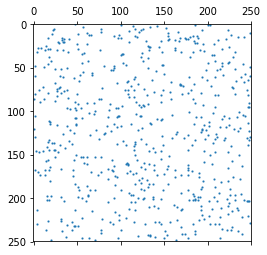

In [4]:
plt.spy(dummy, markersize=1);

In [5]:
print(dummy)

  (137, 129)	0.05409563715292309
  (219, 194)	0.12676575598664064
  (236, 77)	0.1297133685024946
  (170, 78)	0.9913235653850567
  (129, 211)	0.8319650607418313
  (179, 121)	0.4852727096924244
  (50, 38)	0.7331880317797461
  (129, 249)	0.07947388309988046
  (173, 169)	0.8207981993058538
  (46, 241)	0.675461135234256
  (64, 136)	0.21879256797804525
  (84, 110)	0.03396910126513719
  (118, 214)	0.6867001717374005
  (101, 236)	0.6995301472373171
  (191, 101)	0.5915974314523315
  (75, 181)	0.8773385273151388
  (25, 14)	0.09964382302244934
  (198, 137)	0.4576743324358349
  (59, 2)	0.6872116290619612
  (162, 138)	0.005728883655892636
  (79, 17)	0.5707762190206077
  (109, 142)	0.1411587614633989
  (224, 31)	0.41961256130139424
  (226, 17)	0.897923863750546
  (89, 118)	0.6354325627216016
  :	:
  (229, 4)	0.8557838376021782
  (223, 56)	0.42981863607576776
  (167, 13)	0.1363390090049006
  (176, 229)	0.6047778926232239
  (44, 223)	0.8098997267890242
  (16, 33)	0.6915070379679459
  (106, 193)	0.9495

Let us convert the sparse array to some dense formats.

In [6]:
type(dummy.A)

numpy.ndarray

In [7]:
type(dummy.toarray())

numpy.ndarray

In [8]:
type(dummy.todense())

numpy.matrixlib.defmatrix.matrix

## 2. Sparse matrix storage schemes

The `scipy.sparse` module provides several formats to store sparse matrices.
Each format has pros and cons, and some are better for some tasks, such as matrix construction, indexing, or linear operations.

### 2.1 List of lists format (LIL)

* Supports indexing, which cannot be done with other sparse matrix formats.
* Changing sparsity structure is efficient, e.g., reading a sparse matrix from a text file.

In [9]:
# Create an empty lil matrix.
mtx = sparse.lil_matrix((4, 5))

In [10]:
# Assign some of the indices, i.e., changing the sparsity.
mtx[:2, [1, 3]] = np.array([[1, 2], [3, 4]])

In [11]:
mtx.toarray()

array([[0., 1., 0., 2., 0.],
       [0., 3., 0., 4., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [12]:
# Read some of the indices.
mtx[:2].toarray()

array([[0., 1., 0., 2., 0.],
       [0., 3., 0., 4., 0.]])

### 2.2 Coordinate format (COO)

A COO matrix is constructed from three lists:
* a list of column indices,
* a list of row indices,
* a list of values,
where each element of those lists represents a non-zero element in the resulting sparse matrix.

This format is well-adapted to build a sparse adjacency matrix from an edge list.

In [13]:
row = np.array([0, 3, 1, 0])  # row coordinates
col = np.array([0, 3, 1, 2])  # column coordinates
data = np.array([4, 5, 7, 9])  # values

mtx = sparse.coo_matrix((data, (row, col)), shape=(4, 4))

In [14]:
mtx.toarray()

array([[4, 0, 9, 0],
       [0, 7, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 5]])

Advantages:
* Fast element-wise operations.
* Fast conversion to other sparse formats.

In [15]:
# Element-wise power.
mtx.power(0.5).toarray()

array([[2.        , 0.        , 3.        , 0.        ],
       [0.        , 2.64575131, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 2.23606798]])

In [16]:
mtx_csr = mtx.tocsr()

Disadvantages:
* Indexing is not possible. (Use LIL instead!)
* Slow at arithmetic operations. (Use CSR, CSC instead!)

**Exercise:** Can you construct the sparse adjacency matrix in `COO` and `LIL` formats for a network given by the following edge list ?

In [17]:
edges = pd.DataFrame(
    {"node_1": [1,1,1,2,3,3,3],
     "node_2": [3,4,5,6,4,5,6],
     "weights": [0.6,0.5,0.7,0.1,0.6,0.1,0.9]
    })
edges

,node_1,node_2,weights
0,1,3,0.6
1,1,4,0.5
2,1,5,0.7
3,2,6,0.1
4,3,4,0.6
5,3,5,0.1
6,3,6,0.9


### 2.3 Compressed sparse row & column formats (CSR & CSC)

In [18]:
# Get the data array
mtx_csr.data

array([4, 9, 7, 5], dtype=int64)

`CSR` is row oriented:
* efficient row slicing
* fast matrix vector products, the right multiplication `CSR * v`

In [19]:
# Get array of column indices for CSR.
mtx_csr.indices

array([0, 2, 1, 3], dtype=int32)

In [20]:
# Matrix-vector product from the right.
v = np.array([1, 1, 1, 1])
mtx_csr.dot(v)

array([13,  7,  0,  5], dtype=int64)

`CSC` is column oriented:
* efficient column slicing
* fast matrix vector products, the left multiplication `v * CSC`

In [21]:
mtx_csc = mtx.tocsc()
# Get array of row indices for CSC
mtx_csc.indices

array([0, 1, 0, 3], dtype=int32)

In [22]:
# vectro-matrix product
v * mtx_csc

array([4, 7, 9, 5], dtype=int64)

Efficient arithmetic operations `CSC + CSC`, `CSR * CSR`, etc.

In [23]:
# Matrix-Matrix product (* is elementwise product on Numpy!)
prod = mtx_csc * mtx_csc
prod.toarray()

array([[16,  0, 36,  0],
       [ 0, 49,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0, 25]], dtype=int64)

In [24]:
prod = mtx_csr @ mtx_csr # @ is matrix product both on numpy and scipy!
prod.toarray()

array([[16,  0, 36,  0],
       [ 0, 49,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0, 25]], dtype=int64)

You can read more about sparse matrix storage schemes [on Wikipedia](https://en.wikipedia.org/wiki/Sparse_matrix#Storing_a_sparse_matrix).

## 3. Linear agebra on sparse matrices

### 3.1 Some basic operations

In [25]:
# sparse matrix from diagonals
A = sparse.spdiags(np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4]]), [-1,0,2], 4, 4)
A.toarray()

array([[1, 0, 3, 0],
       [1, 2, 0, 4],
       [0, 2, 3, 0],
       [0, 0, 3, 4]])

**Inversion of a sparse matrix**

In [26]:
A = A.tocsc()  # Convert it to CSC matrix for efficiency.
Ainv = sparse.linalg.inv(A)
Ainv.toarray()

array([[ 0.66666667,  0.33333333, -0.33333333, -0.33333333],
       [-0.16666667,  0.16666667,  0.33333333, -0.16666667],
       [ 0.11111111, -0.11111111,  0.11111111,  0.11111111],
       [-0.08333333,  0.08333333, -0.08333333,  0.16666667]])

In [27]:
sparse.linalg.norm(A)  # Default to Frobenius norm.

8.306623862918075

**Solve $A x = b$**

In [28]:
b = np.array([1, 1, 1, 1])
x = sparse.linalg.spsolve(A, b)
x

array([0.33333333, 0.16666667, 0.22222222, 0.08333333])

### 3.2 Eigenvalue decomposition

For the full eigendecomposition of an array, you can use the functions provided by Numpy:
* `numpy.linalg.eig`
* `numpy.linalg.eigvals`
* `numpy.linalg.eigh`
* `numpy.linalg.eighvals`

Scipy presents more functionality (read [here](https://www.scipy.org/scipylib/faq.html#why-both-numpy-linalg-and-scipy-linalg-what-s-the-difference)) such as solving generalized eigenvalue problem, you can use the functions from Scipy:
* `scipy.linalg.eig`
* `scipy.linalg.eigvals`
* `scipy.linalg.eigh`
* `scipy.linalg.eighvals`

In [29]:
linalg.eigvals(A.toarray())

array([1.16822694+2.48096949j, 1.16822694-2.48096949j,
       1.57169108+0.j        , 6.09185505+0.j        ])

Decomposition of an Hermitian matrix:

In [30]:
A = np.array([[1, -2j], [2j, 5]])
linalg.eigvalsh(A)

array([0.17157288, 5.82842712])

However, for quickly finding a few eigenvalues of a large sparse matrix, you should use the corresponding functions from the [sparse module](https://docs.scipy.org/doc/scipy/reference/tutorial/arpack.html):

* `scipy.sparse.eigs`
* `scipy.sparse.eigsh`

In [31]:
dummy = sparse.random(30, 30, density=0.01)
evals, evecs = sparse.linalg.eigs(dummy, k=5, which='SM')
evals

array([ 2.77793090e-18+0.00000000e+00j, -4.94872981e-17+0.00000000e+00j,
        7.58308618e-19+0.00000000e+00j,  1.73472373e-18+1.74175441e-17j,
        1.73472373e-18-1.74175441e-17j])